In [ ]:
'''
    Setup the project
'''
ALL_FLAGS = ['ENABLE_PHASE_TIMING', 'ENABLE_DEBUG', 'ENABLE_RANDOM_SAMPLING', 'ENABLE_NORMAL']
# Make directory build if it doesn't exist
!mkdir -p build
!cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make

: 

In [ ]:
# Install the python packages
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Experiments for PSRS

In [55]:
# Helper functions for running the experiments

def runProgram(numElements, seed, useUniprocessor, numThreads=1):
    '''
        Runs the program and capture the results
        The command to run is `cd build && ./main {numThreads} {numElements} {seed} {useUniprocessor}`` which outputs
        ['p: numThreads n: numElements seed: seed useUniprocessor: useUniprocessor', 'time', 'Success'] where time is in nanoseconds
    '''
    sys.stdout.flush()
    result = !cd build && ./main {numThreads} {numElements} {seed} {useUniprocessor}
    try:
        assert result[-1] == 'Success', 'Experiment failed'
    except:
        print('Error in running the program')
        print(result)
        print('Trying again')
        result = !cd build && ./main {numThreads} {numElements} {seed} {useUniprocessor}
        assert result[-1] == 'Success', 'Experiment failed'
        
    return result

def collectData(numElements, seed, useUniprocessor, times=7, numThreads=1):
    '''
        Collects the time data by running the program multiple times with different seeds but same number of elements
    '''
    data = []
    for i in range(times):
        newSeed = seed+(i+1)*20
        print(f'Running program {i+1}/{times} for numElements={numElements} seed={newSeed} useUniprocessor={useUniprocessor} numThreads={numThreads}')
        result = runProgram(numElements, newSeed, useUniprocessor, numThreads)
        data.append(result)
    return data
    
def collectTimingData(numElements, seed, numThreads, lastRuns=5, times=7):
    '''
        Collects the timing data by running collectData for all threads and then averaging the last 5 runs
    '''
    print(f'Collecting timing data for numElements={numElements} seed={seed} maxThreads={numThreads}')
    assert lastRuns <= times, 'lastRuns should be less than or equal to times'
    data = []
    time_uniprocessor = [int(x[1]) for x in collectData(numElements, seed, 1, times)]
    data.append((1, sum(time_uniprocessor[-lastRuns:])/lastRuns))
    for i in range(2, numThreads+1):
        time = [int(x[1]) for x in collectData(numElements, seed, 0, times, i)]
        # take avg of last x runs
        avg = sum(time[-lastRuns:])/lastRuns
        data.append([i, avg])
    return data
def collectPhaseTimingData(numElements, seed, numThreads, lastRuns=5, times=7):
    '''
        Collects the phase timing data by running collectData for all threads and then averaging the last 5 runs for each phase
    '''
    print(f'Collecting phase timing data for numElements={numElements} seed={seed} maxThreads={numThreads}')
    assert lastRuns <= times, 'lastRuns should be less than or equal to times'
    data = []
    for i in range(2, numThreads+1):
        result = collectData(numElements, seed, 0, times, i)
    
    return data
    
    
def writeToCSV(filename, data, header):
    '''
        Writes the data to a csv file
    '''
    df = pd.DataFrame(data, columns=header)
    df.to_csv(filename, index=False)
    print(f'Wrote data to {filename}')

def saveTimingData(experiment_data, id):
    writeToCSV(f'experiment{id}.csv', experiment_data, ['numThreads', 'time'])
    experiment_speedup = list(map(lambda x: (x[0], experiment_data[0][1]/x[1]), experiment_data))
    writeToCSV(f'experiment{id}_speedup.csv', experiment_speedup, ['numThreads', 'speedup'])

def savePhaseTimingData(experiment_data, id):
    print("Do nothing")

def runAndSaveExperiment(numElements, seed, threads, id, collect, save):
    print(f'Running experiment id: {id}')
    experiment_data = collect(numElements, seed, threads)
    save(experiment_data, id)
    
def getPerfExperimentSettings():
    MAX_THREADS = 16
    seed = 100
    numElements = 10000000
    NUM_ELEMENTS_MULTIPLIER = 2
    experiment_settings = []
    SEED_STEP = 13
    NUM_EXPERIMENTS = 8
    for i in range(1, NUM_EXPERIMENTS):
        experiment_settings.append((numElements, seed, MAX_THREADS, f"perf_{i}"))
        numElements = numElements * NUM_ELEMENTS_MULTIPLIER
        seed = seed + SEED_STEP
    return experiment_settings

def getPhaseTimingExperimentSettings():
    experiment_settings = []
    numElements = 1000000
    NUM_ELEMENTS_MULTIPLIER = 2
    MAX_THREADS = 16
    seed = 200
    SEED_STEP = 13
    for i in range(1, 5):
        experiment_settings.append((numElements, seed, MAX_THREADS, f"phase_timing_{i}"))
        numElements = numElements * NUM_ELEMENTS_MULTIPLIER
        seed = seed + SEED_STEP
        
    return experiment_settings

def runPerformanceExperiments():
    '''
        These experiments run PSRS on different number of threads and different number of elements. While keeping the seeds constant
    '''
    # Recompiling the program with all flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make
    experiment_settings = getPerfExperimentSettings()
    for experiment in experiment_settings:
        runAndSaveExperiment(*experiment, collectTimingData, saveTimingData)
        
def runPhaseTimingExperiments():
    '''
        These experiments run PSRS on different number of threads with a fixed number of elements and seeds.The purpose is to measure the time taken by each phase.
    '''
    # Recompiling the program with the flag ENABLE_PHASE_TIMING and all other flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=ON -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make
    experiment_settings = getPhaseTimingExperimentSettings()
    for experiment in experiment_settings:
        runAndSaveExperiment(*experiment, collectPhaseTimingData, savePhaseTimingData)

def runCorrectnessExperiments():
    '''
        These experiments run PSRS on small number of elements and seeds to check the correctness of the implementation. The number of threads is also varied.
    '''
    # Recompiling the program with the flag ENABLE_PHASE_TIMING and all other flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=ON -DENABLE_DEBUG=ON -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make

def runRegularVsRandomSamplingExperiments():
    '''
        These experiments run PSRS with regular sampling and random sampling on different number of elements and seeds, while keeping the number of threads constant.
    '''
    # First run the experiments with regular sampling
    # Recompiling the program with all flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make
    
    # Then run the experiments with random sampling
    # Recompiling the program with the flag ENABLE_RANDOM_SAMPLING and all other flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=ON -DENABLE_NORMAL=OFF && make
    
def runNormalVsUniformExperiments():
    '''
        These experiments run PSRS with normal distribution and uniform distribution on different number of elements and seeds, while keeping the number of threads constant.
    '''
    # First run the experiments with uniform distribution
    # Recompiling the program with all flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=OFF && make
    
    # Then run the experiments with normal distribution
    # Recompiling the program with the flag ENABLE_NORMAL and all other flags disabled
    !cd build && cmake .. -DENABLE_PHASE_TIMING=OFF -DENABLE_DEBUG=OFF -DENABLE_RANDOM_SAMPLING=OFF -DENABLE_NORMAL=ON && make

In [36]:
runPerformanceExperiments()

Running experiment 1 for numElements=10000000 seed=100 maxThreads=16
Running program 1/7 for numElements=10000000 seed=120 useUniprocessor=1 numThreads=1
Running program 2/7 for numElements=10000000 seed=140 useUniprocessor=1 numThreads=1
Running program 3/7 for numElements=10000000 seed=160 useUniprocessor=1 numThreads=1
Running program 4/7 for numElements=10000000 seed=180 useUniprocessor=1 numThreads=1
Running program 5/7 for numElements=10000000 seed=200 useUniprocessor=1 numThreads=1
Running program 6/7 for numElements=10000000 seed=220 useUniprocessor=1 numThreads=1
Running program 7/7 for numElements=10000000 seed=240 useUniprocessor=1 numThreads=1
Running program 1/7 for numElements=10000000 seed=120 useUniprocessor=0 numThreads=2
Running program 2/7 for numElements=10000000 seed=140 useUniprocessor=0 numThreads=2
Running program 3/7 for numElements=10000000 seed=160 useUniprocessor=0 numThreads=2
Running program 4/7 for numElements=10000000 seed=180 useUniprocessor=0 numThread

In [59]:
runPhaseTimingExperiments()

-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- IPO is supported
-- Configuring done
-- Generating done
-- Build files have been written to: /home/qasimkhawaja/PSRS/build
[ 20%] Built target engine
Scanning dependencies of target main
[ 40%] Building CXX object CMakeFiles/main.dir/app/main.cpp.o
[ 60%] Linking CXX executable main
[ 60%] Built target main
[100%] Built target unit_tests
Running experiment id: phase_timing_1
Running program 1/7 for numElements=1000000 seed=220 useUniprocessor=0 numThreads=2
Running program 2/7 for numElements=1000000 seed=240 useUniprocessor=0 numThreads=2
Running program 3/7 for numElements=1000000 seed=260 useUniprocessor=0 numThreads=2
Running program 4/7 for numElements=1000000 seed=280 useUniprocessor=0 numThreads=2
Running program 5/7 for numElements=1000000 seed=300 useUniprocessor=0 numThreads=2
Running program 6/7 for numElements=1000000 seed=320 useUniprocessor=0 numThreads=2
Running program 7/7 for numElements=1000000 seed=340 useUn

: 

In [ ]:
runCorrectnessExperiments()

In [ ]:
runRegularVsRandomSamplingExperiments()

In [43]:
runNormalVsUniformExperiments()

NameError: name 'runNormalVsUniformExperiments' is not defined

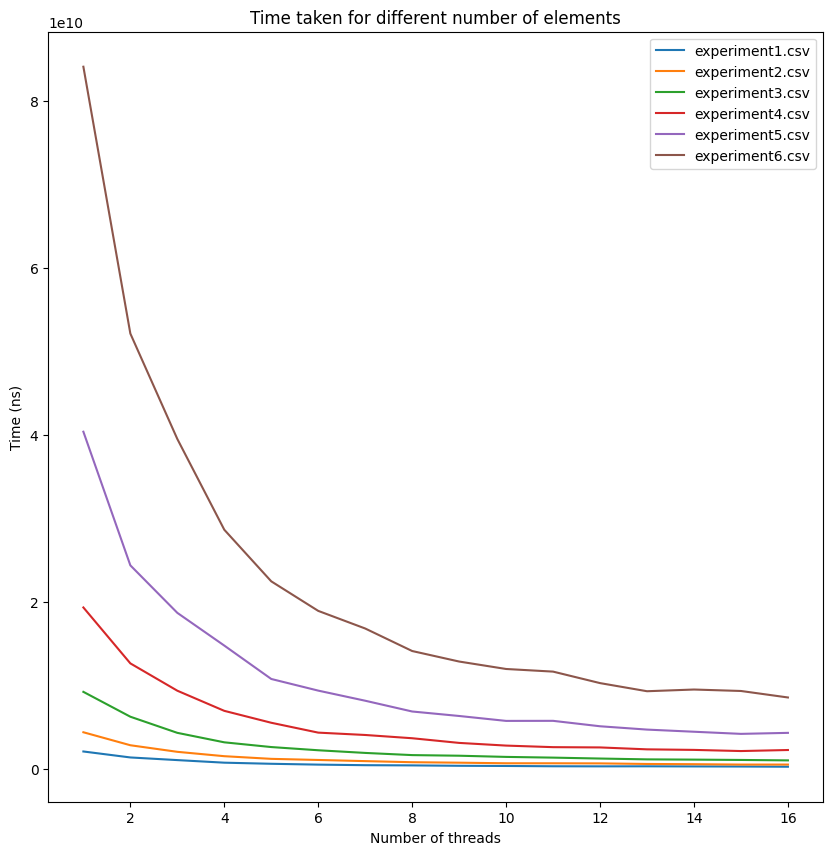

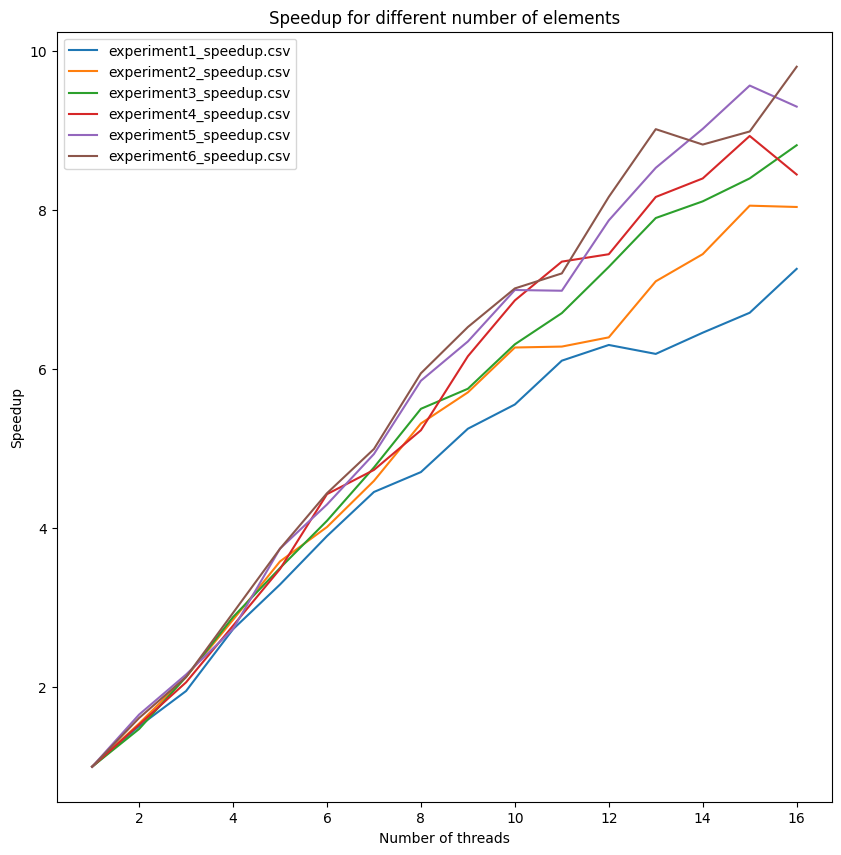

In [41]:
# Helper functions for plotting the results
def plotExperiments(experiments, title, xlabel, ylabel, filename, header):
    '''
        Plots the experiments
    '''
    plt.figure(figsize=(10, 10))
    for experiment in experiments:
        df = pd.read_csv(experiment)
        plt.plot(df[header[0]], df[header[1]], label=experiment)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(filename)
times_files = [f"experiment{i}.csv" for i in range(1, 7)]
speedup_files = [f"experiment{i}_speedup.csv" for i in range(1, 7)]
plotExperiments(times_files, 'Time taken for different number of elements', 'Number of threads', 'Time (ns)', 'time.png', ['numThreads', 'time'])
plotExperiments(speedup_files, 'Speedup for different number of elements', 'Number of threads', 'Speedup', 'speedup.png', ['numThreads', 'speedup'])